# HA 2 - Birds

In [1]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import seaborn as sns
import xarray as xa
import matplotlib.pyplot as plt

az.style.use('arviz-white')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


You run some bird platform and experiment with recommender and censorship systems.

Improving recommendations or censorship leads to 

* higher/lower recommendation engagement (**people follow the thread**)
* higher/lower **reading time** (the spend more time reading threads)
* There are **like buttons** people tap to further engage

Some historical background stuff

* Historical recommendation engagement **5%**
* Historical reading time is **Exponential** with historical average reading time 1m (60s)
* **40%** topicstarters are liked

In [2]:
from typing import Union
from dataclasses import dataclass
from pymc.distributions.distribution import Distribution
from matplotlib.ticker import FuncFormatter

@dataclass
class HistoricalEstimations:
    recommendation_engagement: float = 0.05
    reading_time: int = 60
    like_buttons: float = 0.4
    reading_time_distribution: Distribution = pm.Exponential    
    profit_per_recommendation_engagement: float = 0.0005
    profit_per_reading_time: float = 0.0005
    profit_per_like_buttons: float = 0.0015
    
@dataclass
class ExperimentExpectations:
    recommendation_engagement: np.ndarray[tuple, ...] = np.array([0.035, 0.035, 0.035, 0.05])
    reading_time: np.ndarray[float, ...] = np.array([0.03, 0.03, 0.03, 0.03])
    like_buttons: np.ndarray[float, ...] = np.array([0.015, 0.015, 0.015, 0.015])


class UpliftPrior:
    def __init__(self, historical: HistoricalEstimations, experiment: ExperimentExpectations):
        self.historical = historical
        self.experiment = experiment
    
    @staticmethod
    def initialize(name: str, baseline: Union[float, int], expected: Union[float, int], dims: list = None) -> None:
        uplift = pm.Deterministic(name=f'uplift_{name}', var=expected - baseline, dims=dims)
        uplift_relative = pm.Deterministic(name=f'uplift_relative_{name}', var=expected / baseline - 1, dims=dims)
    
    def initialize_recommendation_engagement(self, dims: list = None) -> Distribution:
        name = 'recommendation_engagement_p'
        historical = self.historical.recommendation_engagement
        experiment = pm.Beta(name=name, 
                             mu=historical,
                             sigma=historical * self.experiment.recommendation_engagement,
                             dims=dims)
        
        self.initialize(name=name, baseline=historical, expected=experiment, dims=dims)
        
        return experiment
    
    def initialize_reading_time(self, dims: list = None) -> Distribution:
        name = 'reading_time_mean'
        historical = self.historical.reading_time
        experiment = pm.Normal(name=name, 
                               mu=historical, 
                               sigma=historical * self.experiment.reading_time,
                               dims=dims)
         
        self.initialize(name=name, baseline=historical, expected=experiment, dims=dims)
        
        return experiment
    
    def initialize_like_buttons(self, dims: list = None) -> Distribution:
        name = 'like_buttons_p'
        historical = self.historical.like_buttons
        experiment = pm.Gamma(name=name, 
                              mu=historical,
                              sigma=historical * self.experiment.like_buttons,
                              dims=dims)
        
        self.initialize(name=name, baseline=historical, expected=experiment, dims=dims)
        
        return experiment
    
    def initialize_recommendation_to_like(self, 
                                          recommendation_engagement: Distribution, 
                                          like_buttons: Distribution,
                                          dims: list = None) -> Distribution:
        name = 'recommendation_to_like_p'
        historical = self.historical.recommendation_engagement * self.historical.like_buttons
        experiment = pm.Deterministic(name=name, var=recommendation_engagement * like_buttons, dims=dims)
        
        self.initialize(name=name, baseline=historical, expected=experiment, dims=dims)
        
        return experiment

    def initialize_recommendation_to_reading_time(self, 
                                                  recommendation_engagement: Distribution,
                                                  reading_time: Distribution,
                                                  dims: list = None) -> Distribution:
        name = 'recommendation_to_reading_time_mean'
        historical = self.historical.recommendation_engagement * self.historical.reading_time
        experiment = pm.Deterministic(name=name, var=recommendation_engagement * reading_time, dims=dims)
        
        self.initialize(name=name, baseline=historical, expected=experiment, dims=dims)
        
        return experiment
    
    def profit_and_losses(self, 
                          uplift_recommendation_engagement: xa.DataArray,
                          uplift_reading_time: xa.DataArray,
                          uplift_like_buttons: xa.DataArray,
                          costs: Union[int, xa.DataArray] = 0,
                          n_users: int = 100000000) -> Union[None, xa.DataArray]:
        return - costs + n_users * (
            uplift_recommendation_engagement * self.historical.profit_per_recommendation_engagement +
            uplift_reading_time * self.historical.profit_per_reading_time + 
            uplift_like_buttons * self.historical.profit_per_like_buttons
        )
        
uplift = UpliftPrior(historical=HistoricalEstimations(), experiment=ExperimentExpectations())

```
impression -> 5% -> read thread ~ Exponential(1/60) -> 40% -> like
          \-> 95% -> scrolls                       \-> 60% did not like
```

You've discussed the possble intervals of the outcomes long time ago and they are the following:

* **+/- 3.5%** change for thread read for the experiments, **except for the D**. For D you considered **+/- 5%**, because it touched sensible censorship topic
* **+/- 3%** for the reading time which was similar across the experiments
* **+/- 1.5%** for all the likes related metrics.

**All are RELATIVE**

* **+/- 3%** relative change is considered significant enough

Grading (total 40)
1. Model: 8pt
    1. Implement the model (2pt)
    2. Display the model structure (2pt)
    3. Sample from it, should have 0 divergences (2pt)
    4. Plot az.forest_plot with rope (2pt)
2. Decision Making: 
    * 8 cases, 4pt each
    * Each plot has to be commented
3. No bonus points this time

In [3]:
outputs = []

data = pd.read_json('ha-2-data.json').T.reset_index().rename(columns={'index': 'experiment'}).set_index('experiment')

reads = data.reads.to_dict()
reads = pd.DataFrame({
    'experiment': sum([[key] * len(value) for key, value in reads.items()], []),
    'time_read': sum([read for read in reads.values()], []),
})
reads['time_read_adj'] = reads.time_read * uplift.historical.recommendation_engagement

zeros = (data.N - data.sN).apply(lambda x: [0] * x).to_dict()
zeros = pd.DataFrame({
    'experiment': sum([[key] * len(value) for key, value in zeros.items()], []),
    'time_read': sum([read for read in zeros.values()], []),
})

reads_extended = pd.concat([reads, zeros]).sort_values(by=['experiment', 'time_read'])

del data['reads'], zeros

In [4]:
reading_time_index, _ = pd.factorize(reads.experiment)

with (pm.Model(name='', coords={'experiment': data.index}) as model):
    recommendation_engagement = uplift.initialize_recommendation_engagement(dims='experiment')
    reading_time = uplift.initialize_reading_time(dims='experiment')
    like_buttons = uplift.initialize_like_buttons(dims='experiment')
    recommendation_to_like = uplift.initialize_recommendation_to_like(
        recommendation_engagement=recommendation_engagement,
        like_buttons=like_buttons,
        dims='experiment',
    )
    recommendation_to_reading_time = uplift.initialize_recommendation_to_reading_time(
        recommendation_engagement=recommendation_engagement,
        reading_time=reading_time,
        dims='experiment',
    )
    
    data_N = pm.Data(name='N', value=data.N, mutable=False)
    data_sN = pm.Data(name='sN', value=data.sN, mutable=False)
    data_likes = pm.Data(name='likes', value=data.likes, mutable=False)
    data_reads = pm.Data(name='reads', value=reads.time_read, mutable=False)
    data_reads_adj = pm.Data(name='reads_extended', value=reads.time_read_adj, mutable=False)
    
    experiment_likelihood_recommendation_engagement = pm.Binomial(
        name='experiment_likelihood_recommendation_engagement',
        n=data_N,
        p=recommendation_engagement,
        observed=data_sN,
    )
    
    experiment_likelihood_reading_time = uplift.historical.reading_time_distribution(
        name='experiment_likelihood_reading_time', 
        lam=1 / reading_time[reading_time_index], 
        observed=data_reads,
    )
    
    experiment_likelihood_like_buttons = pm.Binomial(
        name='experiment_likelihood_like_buttons',
        n=data_sN,
        p=like_buttons,
        observed=data_likes,
    )
    
    experiment_likelihood_recommendation_to_like = pm.Binomial(
        name='experiment_likelihood_recommendation_to_like',
        n=data_N,
        p=recommendation_to_like,
        observed=data_likes,
    )

    experiment_likelihood_recommendation_to_reading_time = uplift.historical.reading_time_distribution(
        name='experiment_likelihood_recommendation_to_reading_time', 
        lam=1 / recommendation_to_reading_time[reading_time_index], 
        observed=data_reads_adj,
    )
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [recommendation_engagement_p, reading_time_mean, like_buttons_p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.


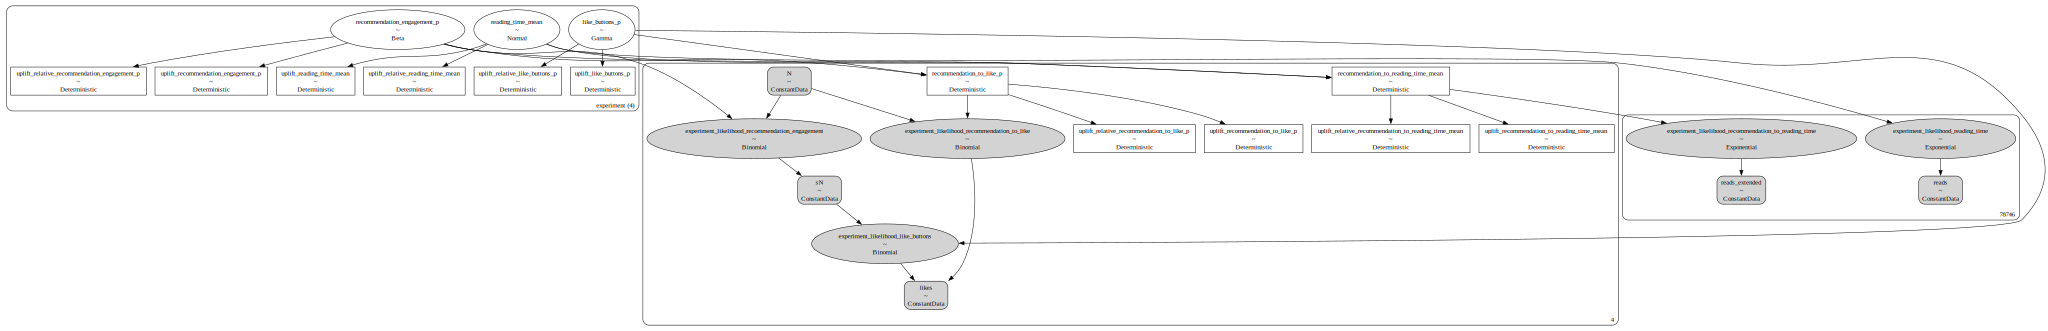

In [5]:
pm.model_to_graphviz(model)

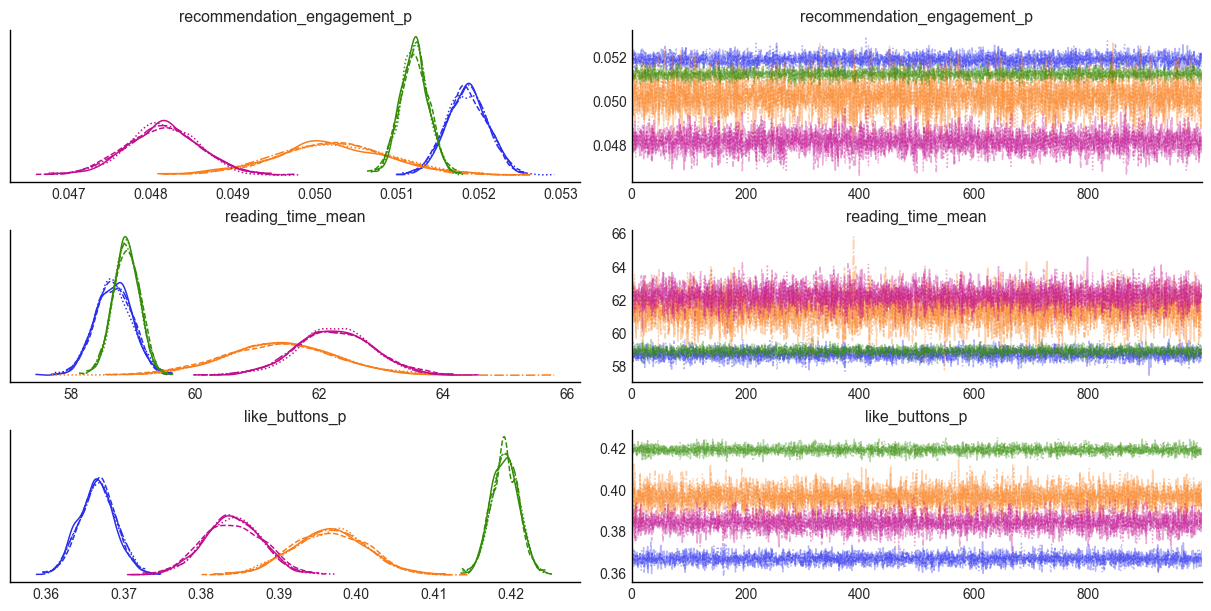

In [34]:
az.plot_trace(trace, var_names=[
    'recommendation_engagement_p',
    'reading_time_mean',
    'like_buttons_p',
])
plt.show()

**What is the best experiment?**

1. Try to answer just looking onto the rope plot...

Значимым изменением мы считаем относительных прирост / уменьшение в размере 3\% (здесь и далее). На приведенном ниже графике видно, что качество рекомендаций значимо не изменяется ни в одной из экспериментов. Аналогичная картина наблюдается для показателя среднего чтения (в секундах). С другой стороны, мы можем наблюдать влияние на количество лайков - в эксперименте А их вероятность значимо снижается, а в эксперименте С, наоборот, увеличивается.

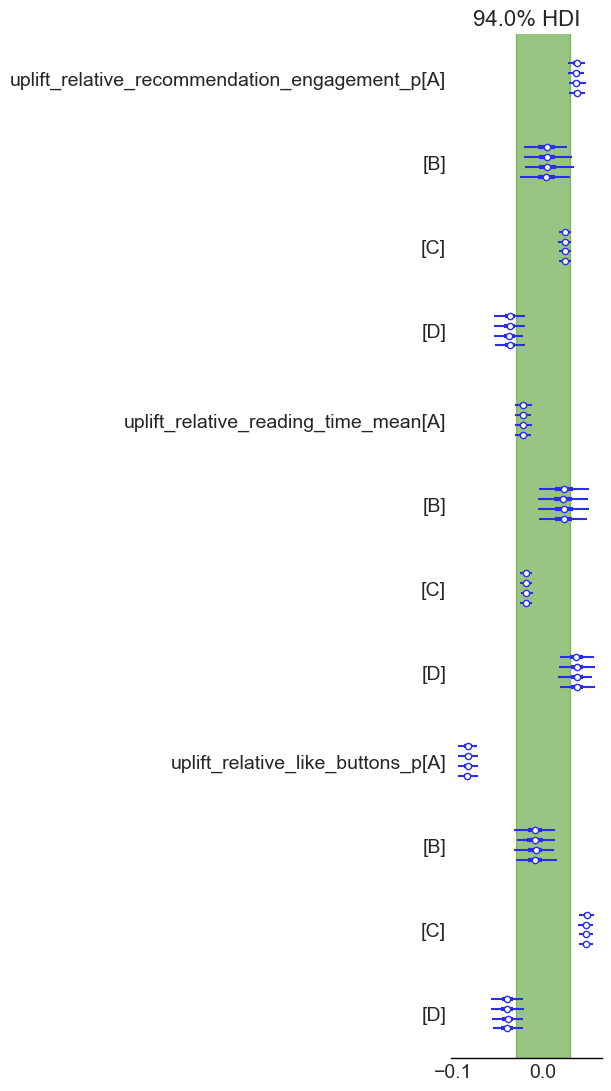

In [6]:
az.plot_forest(trace, var_names=[
    'uplift_relative_recommendation_engagement_p',
    'uplift_relative_reading_time_mean',
    'uplift_relative_like_buttons_p',
], rope=[-0.03, 0.03])
plt.show()

2. Experiment that maximizes likes *after a recommendation*

Картина, полученная для вероятности лайка после получения удачной рекомендации не сильно отличается от предыдущих наблюдений. Тем не менее, в данном случае эксперименты А и D приводят к значимому ухудшению этого показателя. С другой стороны эксперимент C все также показывает значимое улучшение. 

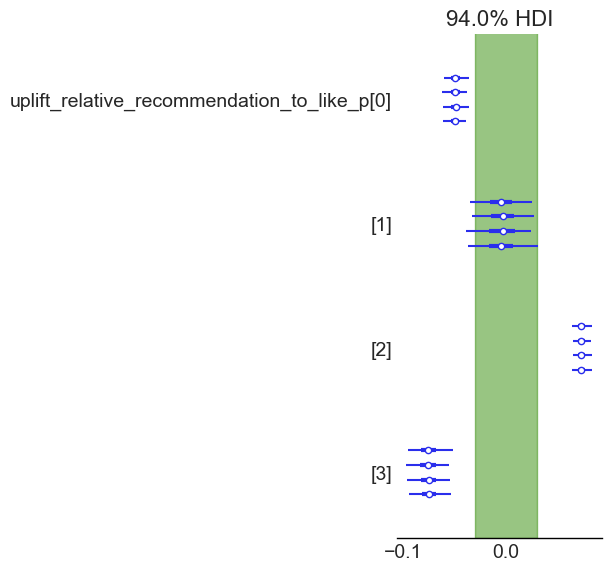

In [7]:
az.plot_forest(trace, var_names=[
    'uplift_relative_recommendation_to_like_p',
], rope=[-0.03, 0.03])
plt.show()

3. Experiment that maximized read time *after a recommendation*

Время чтения после рекомендации ни в одной из экспериментов значимо не изменятся.

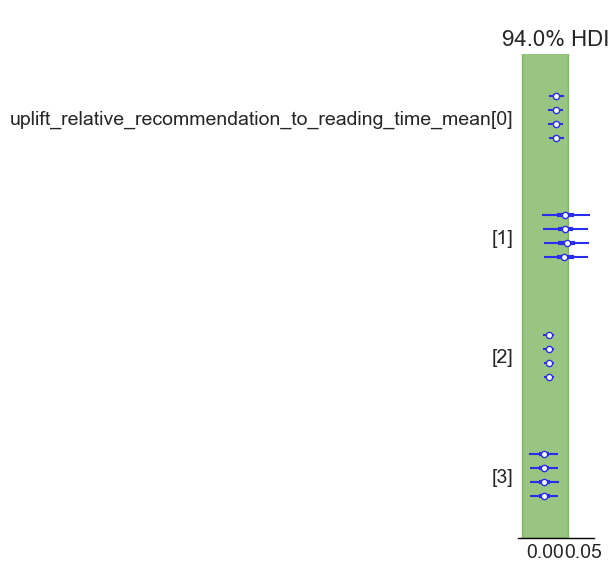

In [8]:
az.plot_forest(trace, var_names=[
    'uplift_relative_recommendation_to_reading_time_mean',
], rope=[-0.03, 0.03])
plt.show()

4. Consider valuing (all at once)
    1. each thread follow up with 0.005$\$
    2. each read second with 0.0005$\$
    3. each like with 0.0015$\$
    4. N users = 100000000


Эксперименты A и C приводят к значимому снижению прибыли портала (согласуется с ранее полученными результатами). Эксперименты B и D приводят к увеличению прибыли, несмотря на то, что эксперимент D имел значимое снижение вероятности лайка после получения хорошей рекомендации, а эксперимент B почте везде показывал незначимые изменения.

In [9]:
def plot_loss(loss_data: xa.DataArray, hue: str = None) -> None:
    sns.barplot(
        y='experiment',
        x='uplift_relative',
        hue=hue,
        data=loss_data.to_dataframe(name='uplift_relative').reset_index(),
        errorbar='sd',
        color='lightblue',
    ).xaxis.set_major_formatter(FuncFormatter(lambda s, a: f'{s / 1000}k'))
    plt.xlabel('implementation profit ($)')
    plt.ylabel('experiment')
    plt.title('Loss function applied to uplifts')
    plt.show()

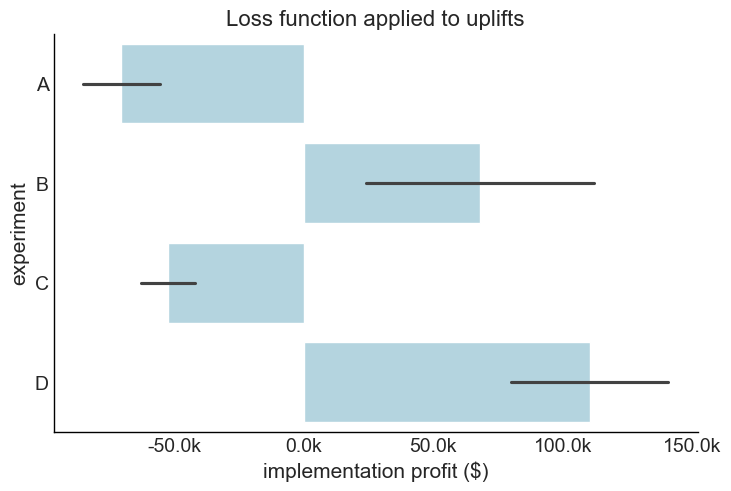

In [10]:
plot_loss(uplift.profit_and_losses(
    uplift_recommendation_engagement=trace['posterior']['uplift_recommendation_engagement_p'],
    uplift_reading_time=trace['posterior']['uplift_reading_time_mean'],
    uplift_like_buttons=trace['posterior']['uplift_like_buttons_p'],
))

5. Consider implementation costs for projects and the previous information
    1. 30000
    2. 20000
    3. 15000
    4. 10000

Картина аналогична тому, что было на предыдущем рисунке, добавление издержек не привело к существенным изменениям в оценке экспериментов.

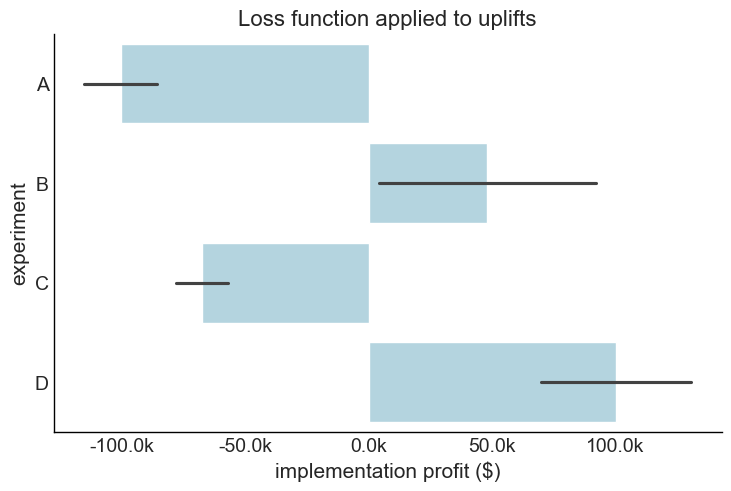

In [11]:
costs = xa.DataArray(data=[30000, 20000, 15000, 10000], coords={'experiment': ['A', 'B', 'C', 'D']})

plot_loss(uplift.profit_and_losses(
    uplift_recommendation_engagement=trace['posterior']['uplift_recommendation_engagement_p'],
    uplift_reading_time=trace['posterior']['uplift_reading_time_mean'],
    uplift_like_buttons=trace['posterior']['uplift_like_buttons_p'],
    costs=costs,
))

6. You are going to face people transitioning to another platform. Overall future engagement is quite unsure. Here are scenarios you consider:
    1. Optimistic: there will be bright future, people will visit the app 5\% more frequently
    2. Conservative: nothing will change
    3. Pessimistic: thought leaders will move to the new platform and take 5\% of the audience implementation costs are 50% more
    4. Depression: thought leaders will move to the new platform and take 15\% of the audience implementation costs are 7 times more

Картина аналогична тому, что было на предыдущем рисунке. Тем не менее можно наблюдать небольшое изменение. Эксперимент B в случе наступления наихудшего сценария может привести в значимо отрицательному результату (минус прибыль). Эксперимент D все также выглядит наиболее привлекательным даже в случе наступления наихудшего сценария. 

/var/folders/rt/5fp_94sx7tj04y9kg1jxgnj40000gn/T/ipykernel_98109/763700858.py:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightblue'` for the same effect.

  sns.barplot(


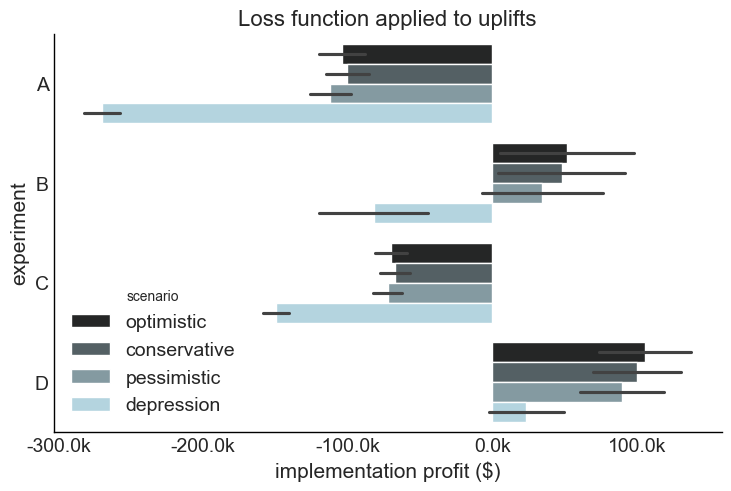

In [12]:
scenario = ['optimistic', 'conservative', 'pessimistic', 'depression']

costs_scenario = xa.DataArray(data=[1, 1, 1.5, 7], coords={'scenario': scenario})
users_scenario = xa.DataArray(data=[1.05, 1, 0.95, 0.85], coords={'scenario': scenario})

plot_loss(uplift.profit_and_losses(
    uplift_recommendation_engagement=trace['posterior']['uplift_recommendation_engagement_p'],
    uplift_reading_time=trace['posterior']['uplift_reading_time_mean'],
    uplift_like_buttons=trace['posterior']['uplift_like_buttons_p'],
    costs=costs * costs_scenario,
    n_users=100000000 * users_scenario,
), hue='scenario')

7. Among the scenarios, find the probability of being the best among the experiments. Show the heatmap; **Mind the x/y ticks, make sure it is not messed up**


Данный рисунок доказывает ранее полученные выводы. Эксперимент B почти в 100\% случаях является наиболее привлекательным с точки зрения прибыли (при любом сценарии). Это также можно наблюдать на втором рисунке (также есть небольшая вероятность того, что эксперимент B окажется лучшим).


In [13]:
def experiment_outcome_versus_all(outcomes: xa.DataArray, experiment: str) -> xa.DataArray:
    return (outcomes.sel(
        experiment=experiment) > outcomes.drop_sel(experiment=experiment).max('experiment')).mean(['chain', 'draw'])

def experiment_outcome(outcomes):
    return xa.concat([
        experiment_outcome_versus_all(outcomes=outcomes, experiment=experiment) 
        for experiment in outcomes.coords['experiment'].values
    ], dim=outcomes.coords['experiment'])    

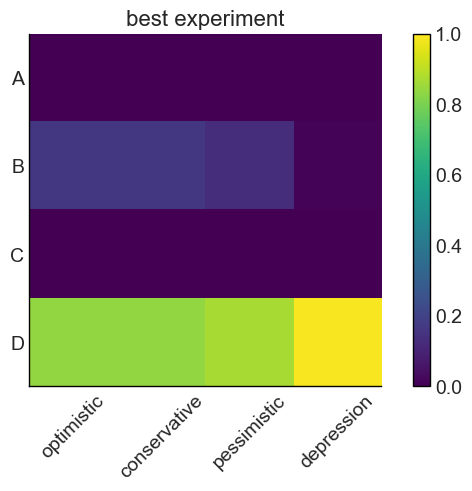

In [14]:
outcomes = uplift.profit_and_losses(
    uplift_recommendation_engagement=trace['posterior']['uplift_recommendation_engagement_p'],
    uplift_reading_time=trace['posterior']['uplift_reading_time_mean'],
    uplift_like_buttons=trace['posterior']['uplift_like_buttons_p'],
    costs=costs * costs_scenario,
    n_users=100000000 * users_scenario,
)

outcomes_decisions = experiment_outcome(outcomes=outcomes)

plt.imshow(outcomes_decisions, vmin=0, vmax=1)
plt.title('best experiment')
plt.yticks(*zip(*enumerate(outcomes_decisions.coords['experiment'].values)))
plt.xticks(*zip(*enumerate(outcomes_decisions.coords['scenario'].values)), rotation=45)
plt.colorbar()
plt.show()

/var/folders/rt/5fp_94sx7tj04y9kg1jxgnj40000gn/T/ipykernel_98109/2685102376.py:1: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightblue'` for the same effect.

  sns.barplot(


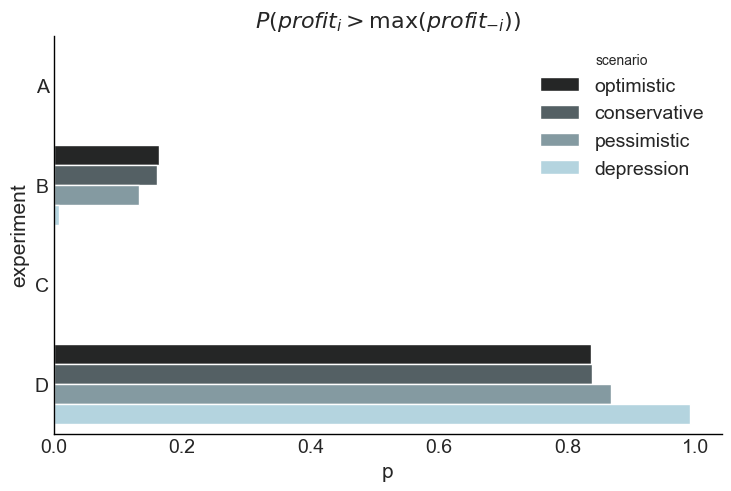

In [15]:
sns.barplot(
    x='p', y='experiment', hue='scenario', color='lightblue',
    data=outcomes_decisions.to_dataframe(name='p').reset_index(),
)
plt.title(r'$P({profit}_i > \max({profit}_{-i}))$')
plt.show()

8. You have to be conservative in the decision, find the 5% lower quantile for each experiment and scenario, show it on the heatmap, center it around zero. **Mind the x/y ticks, make sure it is not messed up**

In [22]:
def experiment_outcome_versus_all_with_q(outcomes: xa.DataArray, experiment: str, q: float) -> xa.DataArray:
    outcomes -= outcomes.min(['experiment', 'scenario'])
    outcomes /= outcomes.max(['experiment', 'scenario'])    
    return outcomes.quantile(q=q, dim=['chain', 'draw']).sel(experiment=experiment)

def experiment_outcome_with_q(outcomes, q: float):
    return xa.concat([
        experiment_outcome_versus_all_with_q(outcomes=outcomes, experiment=experiment, q=q) 
        for experiment in outcomes.coords['experiment'].values
    ], dim=outcomes.coords['experiment'])

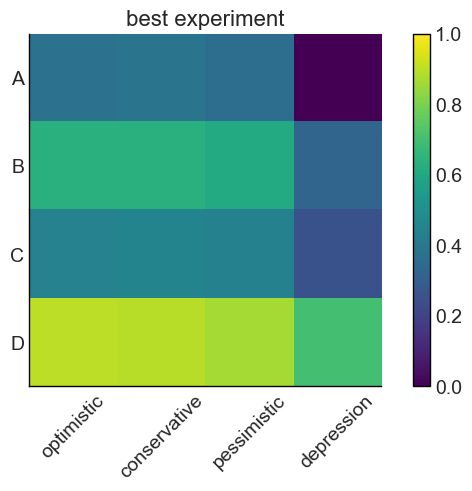

In [23]:
outcomes = uplift.profit_and_losses(
    uplift_recommendation_engagement=trace['posterior']['uplift_recommendation_engagement_p'],
    uplift_reading_time=trace['posterior']['uplift_reading_time_mean'],
    uplift_like_buttons=trace['posterior']['uplift_like_buttons_p'],
    costs=costs * costs_scenario,
    n_users=100000000 * users_scenario,
)

outcomes_decisions = experiment_outcome_with_q(outcomes=outcomes, q=0.05)

plt.imshow(outcomes_decisions, vmin=0, vmax=1)
plt.title('best experiment')
plt.yticks(*zip(*enumerate(outcomes_decisions.coords['experiment'].values)))
plt.xticks(*zip(*enumerate(outcomes_decisions.coords['scenario'].values)), rotation=45)
plt.colorbar()
plt.show()